# Setup

In [24]:
import numpy as np
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt

In [42]:
# error dict
error_labels = {
    "Cannot find name 'clone'. Did you mean 'close'?" : "Cannot find name (suggestion).",
    "Cannot use JSX unless the '--jsx' flag is provided." : "JSX",
    "Left side of comma operator is unused and has no side effects." : "Left side comma operator unused"
}

def getLabels(errors):
    errors = list(errors)
    for i, e in enumerate(errors):
        if e in error_labels:
            e = error_labels[e]
        else:
            if e.endswith("."):
                e = e[:-1]
        errors[i] = e
    return errors

In [59]:
#classes
class Log:
    def __init__(self, filename):
        
        rows = []
        self.snippets = None
        self.noErrors = None

        file = open(filename, encoding="utf8")
        headings = []
        csv_mode = False
        for line in file.readlines():
            line = line.strip()
            if line.startswith("ERROR, CODE, CATEGORY, NUM OCCURANCES, NUM AFFECTED SNIPPETS, FIRST ID, PERCENT"):
                csv_mode = True
                headings = line.split(",")
                headings = [h.strip() for h in headings]
                continue
            if(csv_mode):
                if not line:
                    csv_mode = False
                    continue
                parts = line.split(",")
                columns = ["".join(parts[0:-6])]
                columns += [float(p.strip()) for p in parts[-6:]]
                rows.append(columns)
                continue
            if line.startswith("Snippets without errors"):
                self.noErrors = int(line.split(":")[1].split("/")[0])
            if line.startswith("TOTAL SNIPPETS:"):
                self.snippets = int(line.split(":")[1].strip())
        
        self.errors = DataFrame.from_records(rows, columns=headings)

In [60]:
#load files
DATA_DIR = "../data";
SAMPLE_DIR = DATA_DIR + "/384-sample.log"
ERRORS_DIR = DATA_DIR + "/finalErrors.log"

errors = Log(ERRORS_DIR)

# Error Analysis

## Overview

In [63]:
print("Total Snippets: " + str(errors.snippets))
print("Snippets with no Errors: " + str(errors.noErrors) + "/" + str(errors.snippets) + "(" + str(errors.noErrors/errors.snippets) + ")")
print("Snippets with Errors: " + str(errors.snippets-errors.noErrors) + "/" + str(errors.snippets) + "(" + str(1 - errors.noErrors/errors.snippets) + ")")

Total Snippets: 2161911
Snippets with no Errors: 584787/2161911(0.270495408922939)
Snippets with Errors: 1577124/2161911(0.729504591077061)


## Most common errors (occurances)

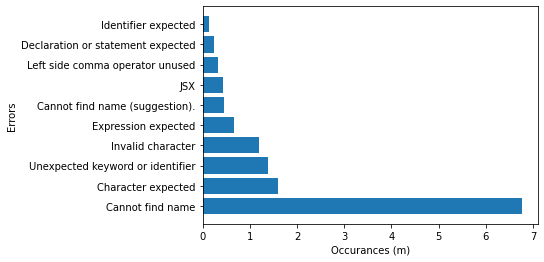

In [45]:
errors_df = errors.errors
top10_df = errors_df.nlargest(10, ['NUM OCCURANCES'])

fig, ax = plt.subplots()
ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM OCCURANCES"])
ax.set_xlabel("Occurances (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))


## Most common errors (snippets affected)

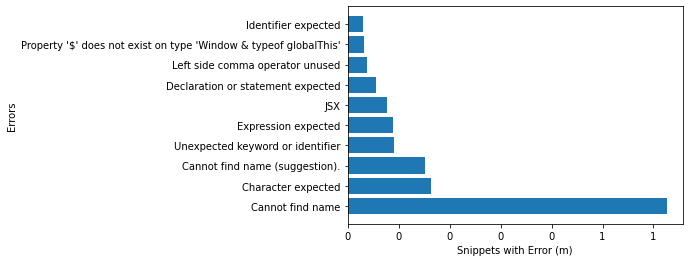

In [48]:
top10_df = errors_df.nlargest(10, ['NUM AFFECTED SNIPPETS'])

fig, ax = plt.subplots()
ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM AFFECTED SNIPPETS"])
ax.set_xlabel("Snippets with Error (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))